In [1]:
import numpy as np
import pandas as pd
import os
import re
import seaborn as sns
from sklearn.base import clone, BaseEstimator, RegressorMixin
from sklearn.metrics import cohen_kappa_score, accuracy_score, mean_squared_error
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import missingno as msno

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error

In [2]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

LOAD DATA

In [3]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')
dict = pd.read_csv('../input/child-mind-institute-problematic-internet-use/data_dictionary.csv')

train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

100%|██████████| 2/2 [00:00<00:00,  9.43it/s]


PREPROCESS CSV

In [4]:
dict

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
...,...,...,...,...,...,...
76,Sleep Disturbance Scale,SDS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
77,Sleep Disturbance Scale,SDS-SDS_Total_Raw,Total Raw Score,int,NaN,NaN
78,Sleep Disturbance Scale,SDS-SDS_Total_T,Total T-Score,int,NaN,NaN
79,Internet Use,PreInt_EduHx-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 59 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      20 non-null     object 
 1   Basic_Demos-Enroll_Season               20 non-null     object 
 2   Basic_Demos-Age                         20 non-null     int64  
 3   Basic_Demos-Sex                         20 non-null     int64  
 4   CGAS-Season                             10 non-null     object 
 5   CGAS-CGAS_Score                         8 non-null      float64
 6   Physical-Season                         14 non-null     object 
 7   Physical-BMI                            13 non-null     float64
 8   Physical-Height                         13 non-null     float64
 9   Physical-Weight                         13 non-null     float64
 10  Physical-Waist_Circumference            5 non-null      float64


<Axes: >

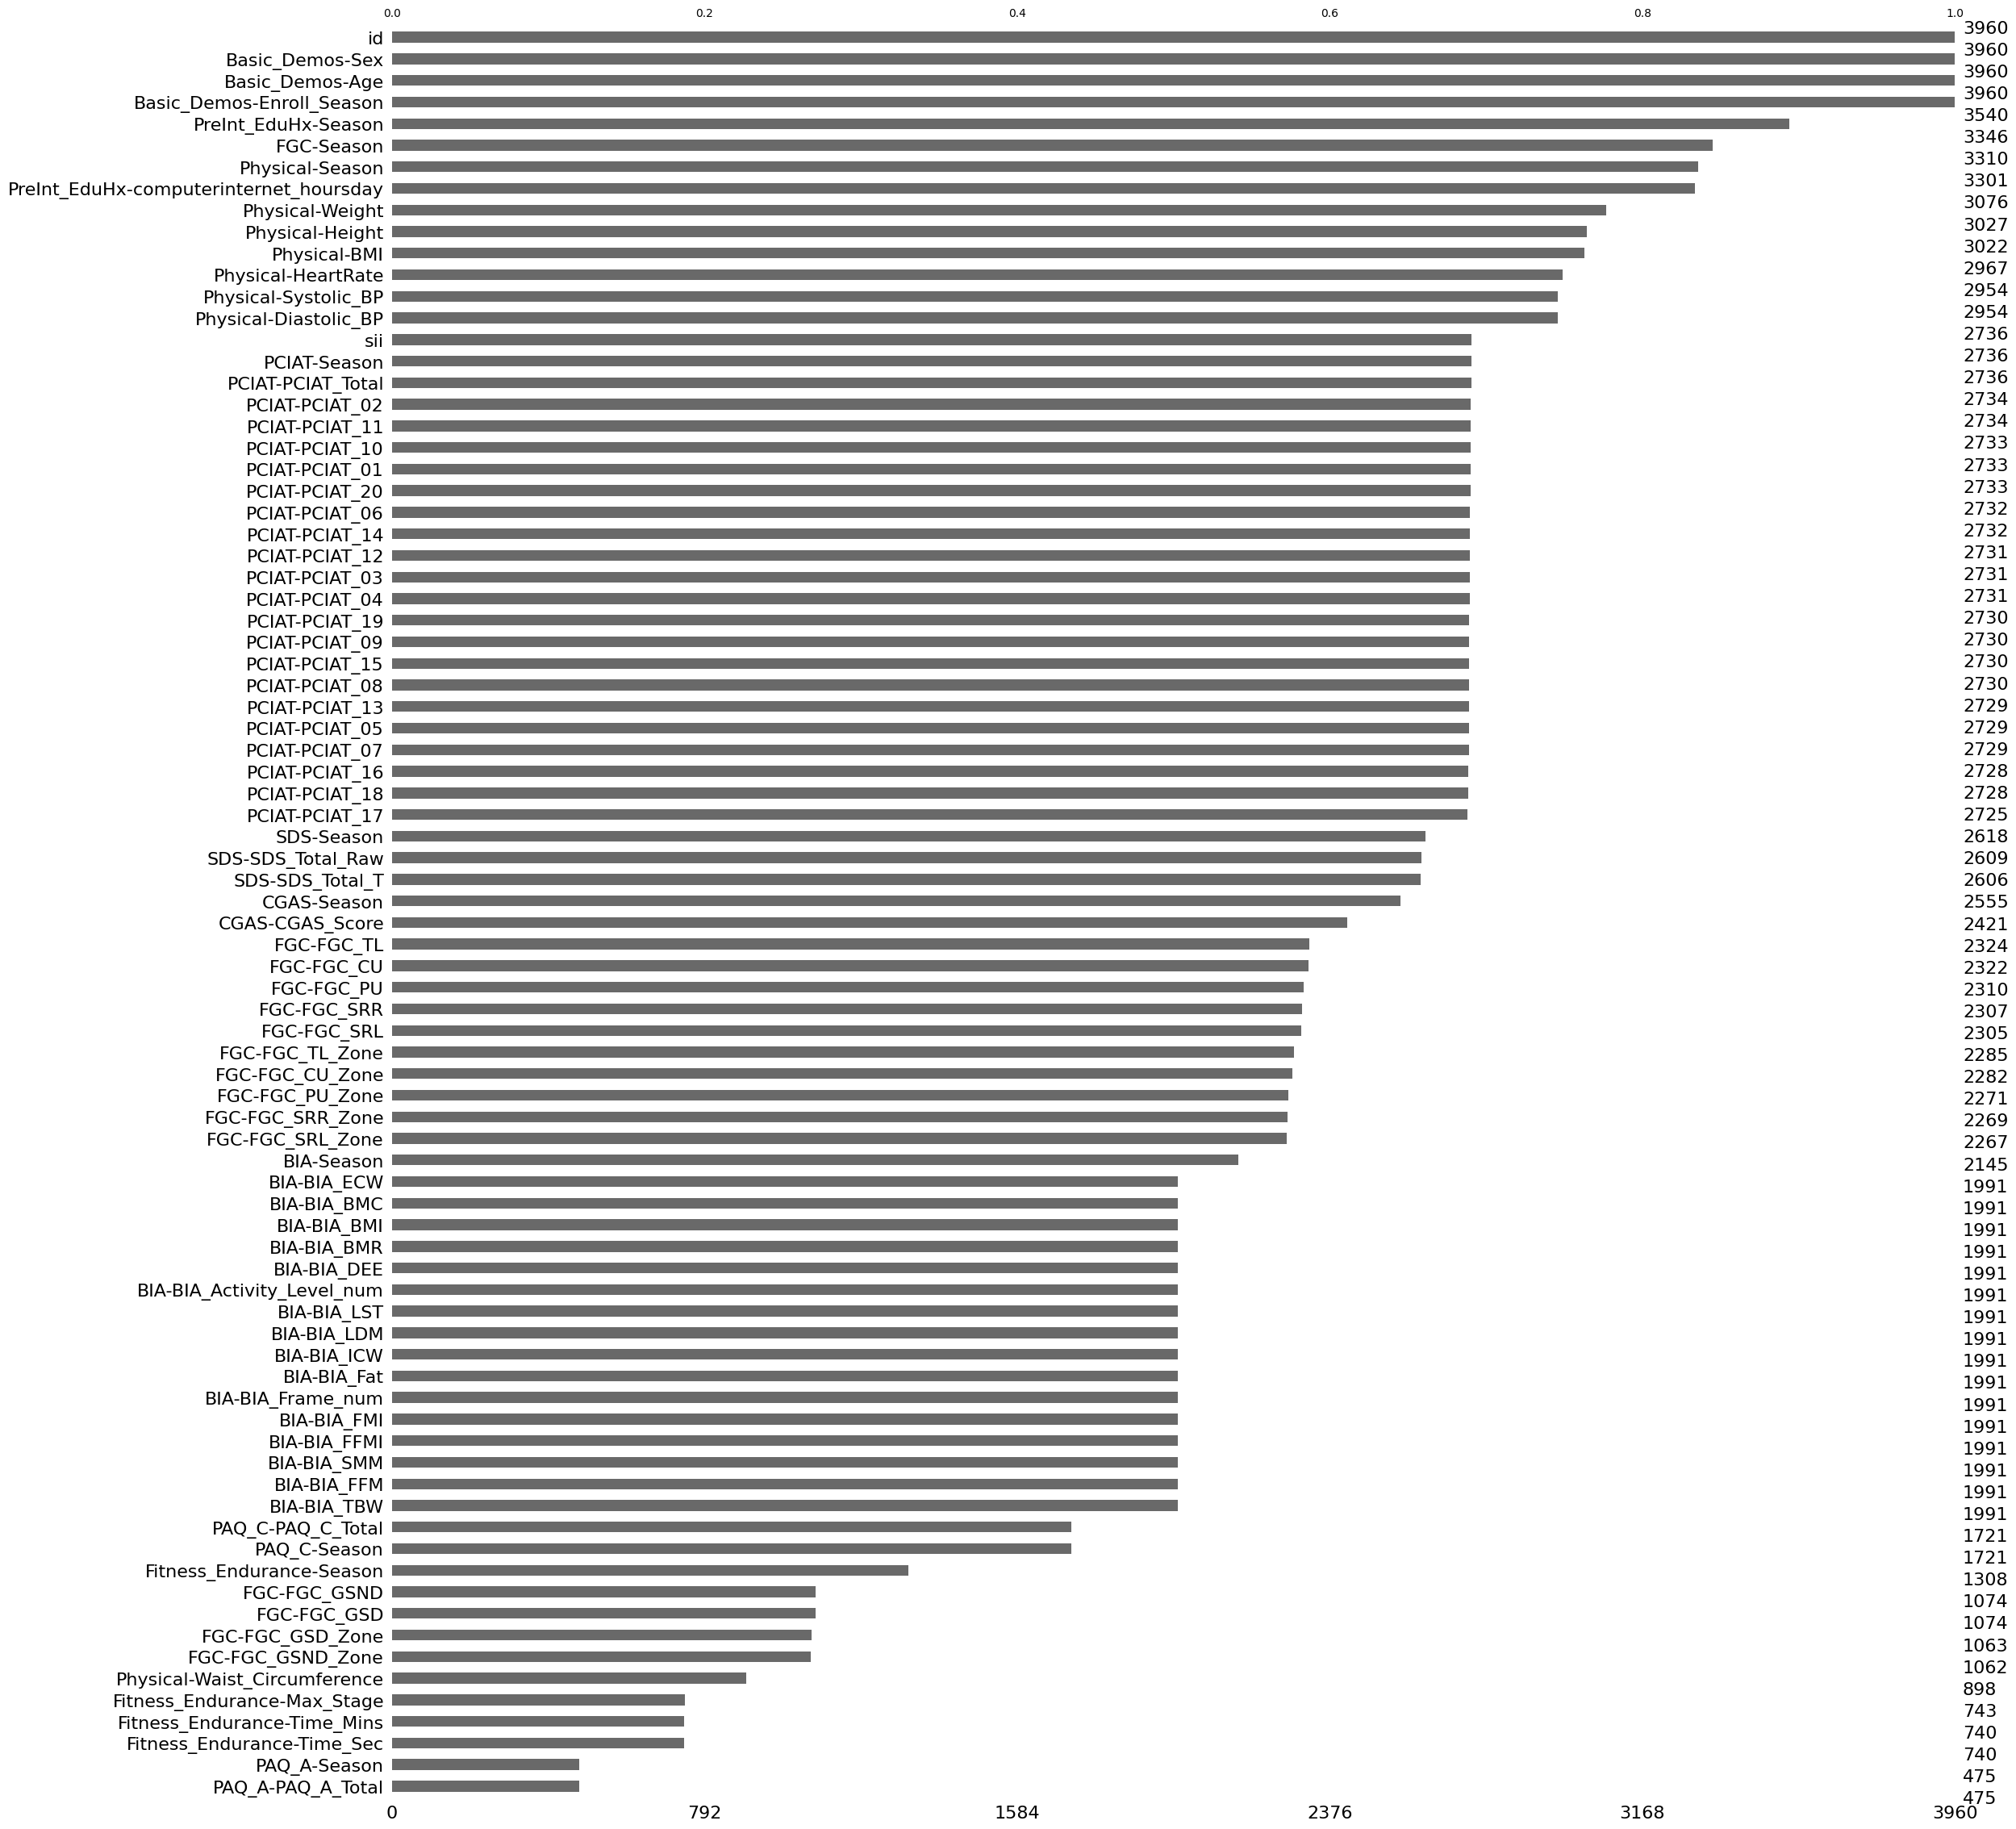

In [7]:
msno.bar(train.iloc[:, :train.shape[1]], sort='ascending')

<Axes: >

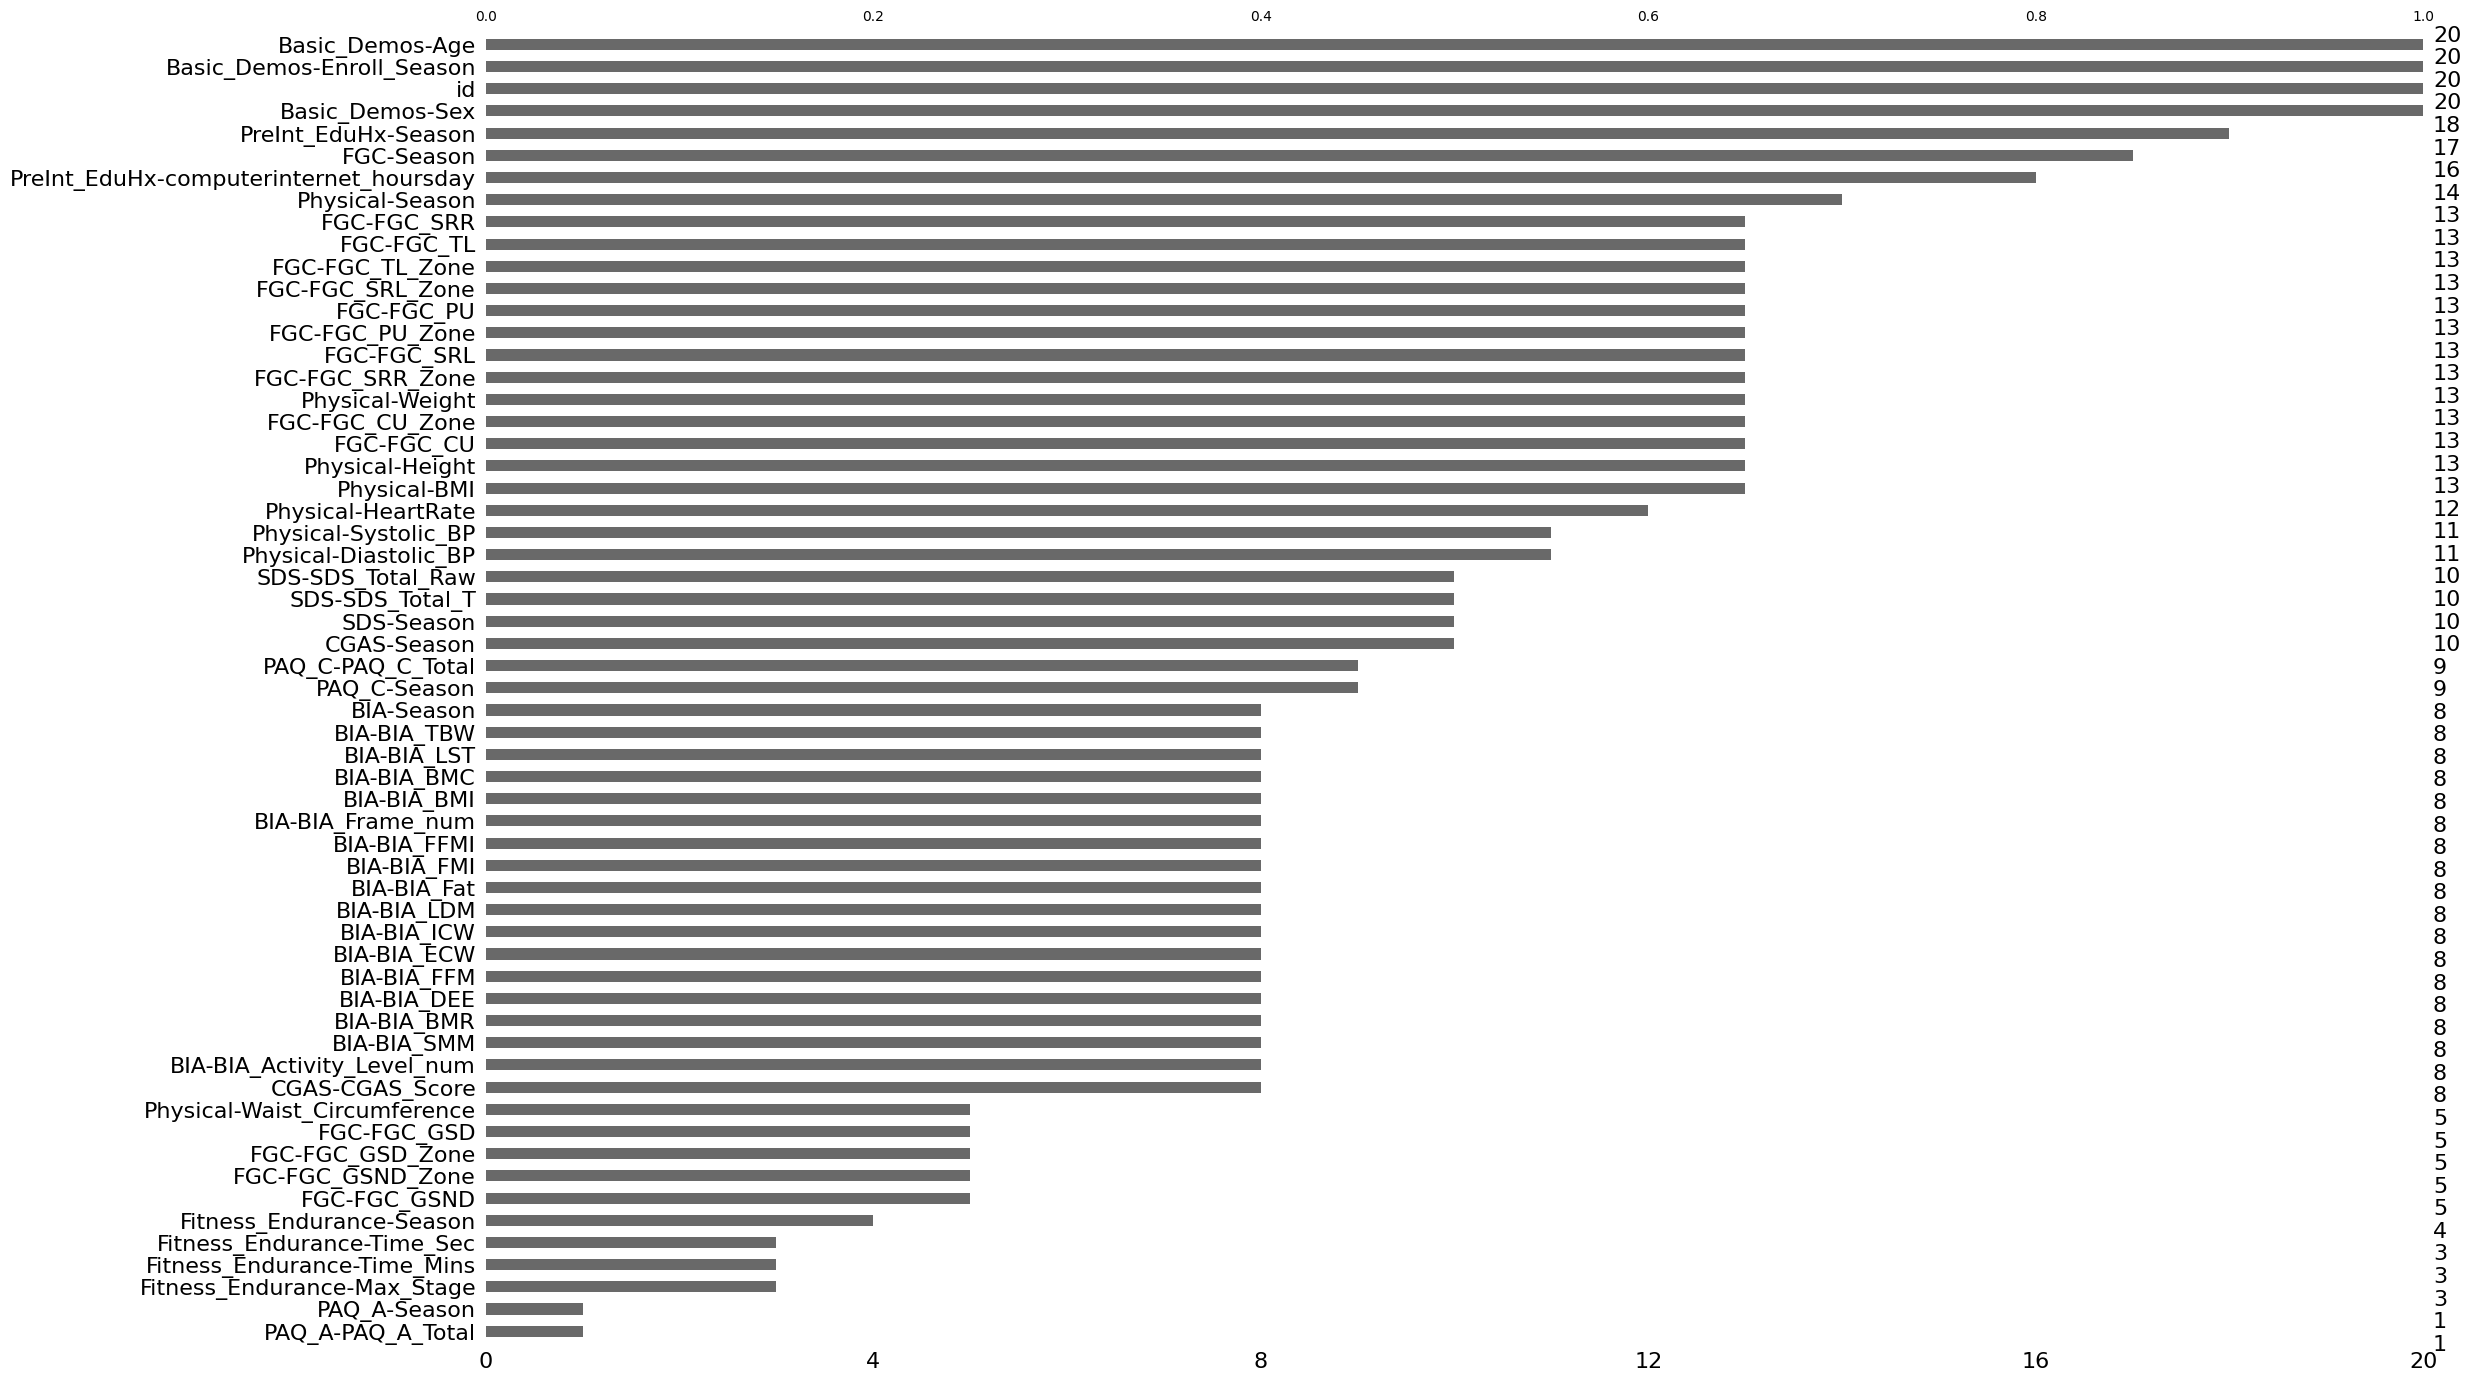

In [8]:
msno.bar(test.iloc[:, :test.shape[1]], sort='ascending')

In [9]:
# Kiểm tra các cột dư thừa ở trong train không có trong test
different_columns = set(train) - set(test)
different_columns # Cột sii là label, cần dữ lại

{'PCIAT-PCIAT_01',
 'PCIAT-PCIAT_02',
 'PCIAT-PCIAT_03',
 'PCIAT-PCIAT_04',
 'PCIAT-PCIAT_05',
 'PCIAT-PCIAT_06',
 'PCIAT-PCIAT_07',
 'PCIAT-PCIAT_08',
 'PCIAT-PCIAT_09',
 'PCIAT-PCIAT_10',
 'PCIAT-PCIAT_11',
 'PCIAT-PCIAT_12',
 'PCIAT-PCIAT_13',
 'PCIAT-PCIAT_14',
 'PCIAT-PCIAT_15',
 'PCIAT-PCIAT_16',
 'PCIAT-PCIAT_17',
 'PCIAT-PCIAT_18',
 'PCIAT-PCIAT_19',
 'PCIAT-PCIAT_20',
 'PCIAT-PCIAT_Total',
 'PCIAT-Season',
 'sii'}

In [10]:
threshold = 0.7
nan_columns = test.columns[test.isna().mean() > threshold]
# Loại bỏ các cột có quá nhiều Nan
# common_columns = train.columns.intersection(test.columns).difference(nan_columns)
common_columns = train.columns.intersection(test.columns)

In [11]:
# Lấy các cột chung giữa train và test

# Tạo lại data chỉ có các cột của test
train_df = train[common_columns]

# Gắn lại label
train_df['sii'] = train['sii']
train = train_df

test = test[common_columns]

In [12]:
# Lấy danh sách các cột trong train
columns_in_train = pd.DataFrame({'Field': train.columns})

# Kết hợp (merge) với dict để lấy giải thích
train_dict= pd.merge(columns_in_train, dict, on='Field', how='left')
train_dict

,Field,Instrument,Description,Type,Values,Value Labels
0,id,Identifier,Participant's ID,str,NaN,NaN
1,Basic_Demos-Enroll_Season,Demographics,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Basic_Demos-Age,Demographics,Age of participant,float,NaN,NaN
3,Basic_Demos-Sex,Demographics,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,CGAS-Season,Children's Global Assessment Scale,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
5,CGAS-CGAS_Score,Children's Global Assessment Scale,Children's Global Assessment Scale Score,int,NaN,NaN
6,Physical-Season,Physical Measures,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
7,Physical-BMI,Physical Measures,Body Mass Index (kg/m^2),float,NaN,NaN
8,Physical-Height,Physical Measures,Height (in),float,NaN,NaN
9,Physical-Weight,Physical Measures,Weight (lbs),float,NaN,NaN


In [13]:
def feature_engineering(df_):
    df = df_.copy()
    # Các chỉ số liên quan giữa thể chất và thời gian dùng internet
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    
    # Tỉ lệ lượng mỡ
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    # Quan hệ giữa cơ và mỡ
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    # Quan hệ giữa mỡ cơ thể và mỡ tổng thế
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    # Tỷ lệ mô mềm và lượng nước
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    # Mỡ * Tốc độ chuyển hóa
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    # Mỡ * Mức năng lượng
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    # Tỷ lệ BMR với cân nặng
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    # Tỷ lệ tiêu thụ năng lượng và cân nặng
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    # Tỷ lệ phát triển cơ bắp và chiều cao
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    # Tỷ lệ co bắp xương / cân nặng
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    # Mức độ Hydrat hóa cơ thể
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    
    df['BMI_PHR'] = df['Physical-BMI'] * df['Physical-HeartRate']

    # df['Age_Weight'] = df['Basic_Demos-Age'] * df['Physical-Weight']
    # df['Sex_BMI'] = df['Basic_Demos-Sex'] * df['Physical-BMI']
    # df['Sex_HeartRate'] = df['Basic_Demos-Sex'] * df['Physical-HeartRate']
    # df['Age_WaistCirc'] = df['Basic_Demos-Age'] * df['Physical-Waist_Circumference']
    # df['BMI_FitnessMaxStage'] = df['Physical-BMI'] * df['Fitness_Endurance-Max_Stage']
    # df['Weight_GripStrengthDominant'] = df['Physical-Weight'] * df['FGC-FGC_GSD']
    # df['Weight_GripStrengthNonDominant'] = df['Physical-Weight'] * df['FGC-FGC_GSND']
    # df['HeartRate_FitnessTime'] = df['Physical-HeartRate'] * (df['Fitness_Endurance-Time_Mins'] + df['Fitness_Endurance-Time_Sec'])
    # df['Age_PushUp'] = df['Basic_Demos-Age'] * df['FGC-FGC_PU']
    # df['FFMI_Age'] = df['BIA-BIA_FFMI'] * df['Basic_Demos-Age']
    # df['InternetUse_SleepDisturbance'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['SDS-SDS_Total_Raw']
    # df['CGAS_BMI'] = df['CGAS-CGAS_Score'] * df['Physical-BMI']
    # df['CGAS_FitnessMaxStage'] = df['CGAS-CGAS_Score'] * df['Fitness_Endurance-Max_Stage']

    
    return df

In [14]:
def season_encode(df, kill_season=False):
    if kill_season:
        season_cols = [col for col in df.columns if 'Season' in col]
        df_ = df.drop(season_cols, axis=1)
        return df_
        
    df_no_id = df.drop(columns='id')
    string_columns = df_no_id.select_dtypes(include=['object']).columns.tolist()
    
    season_encode_map = {
        'Spring': 1,
        'Summer': 2,
        'Fall': 3,
        'Winter': 4,
        np.nan: 0
    }

    # Áp dụng mapping cho tất cả các cột kiểu string
    df_no_id[string_columns] = df_no_id[string_columns].apply(lambda col: col.map(season_encode_map))
    df_no_id['id'] = df['id']
    return df_no_id

In [15]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim*3),
            nn.ReLU(),
            nn.Linear(encoding_dim*3, encoding_dim*2),
            nn.ReLU(),
            nn.Linear(encoding_dim*2, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim*2),
            nn.ReLU(),
            nn.Linear(input_dim*2, input_dim*3),
            nn.ReLU(),
            nn.Linear(input_dim*3, input_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [16]:
def perform_autoencoder(df, encoding_dim=50, epochs=50, batch_size=32):
    # Scale lại data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    
    data_tensor = torch.FloatTensor(df_scaled)
    
    input_dim = data_tensor.shape[1]
    autoencoder = AutoEncoder(input_dim, encoding_dim)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters())

    # Huấn luyện mô hình Autoencoder
    for epoch in range(epochs):
        for i in range(0, len(data_tensor), batch_size):
            batch = data_tensor[i : i + batch_size]
            optimizer.zero_grad()
            reconstructed = autoencoder(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}]')

    # Encoder dữ liệu - Chỉ lấy phần encoder
    with torch.no_grad():
        encoded_data = autoencoder.encoder(data_tensor).numpy()
        
    df_encoded = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])])
    
    return df_encoded

In [17]:
df_train = train_ts.drop('id', axis=1)
df_test = test_ts.drop('id', axis=1)

print("Train encode")
train_ts_encoded = perform_autoencoder(df_train, encoding_dim=70, epochs=200, batch_size=32)
print("Test encode")
test_ts_encoded = perform_autoencoder(df_test, encoding_dim=70, epochs=200, batch_size=32)

Train encode
Epoch [10/200], Loss: 1.6832]
Epoch [20/200], Loss: 1.6098]
Epoch [30/200], Loss: 1.5669]
Epoch [40/200], Loss: 1.5375]
Epoch [50/200], Loss: 1.5292]
Epoch [60/200], Loss: 1.5115]
Epoch [70/200], Loss: 1.5053]
Epoch [80/200], Loss: 1.4802]
Epoch [90/200], Loss: 1.4780]
Epoch [100/200], Loss: 1.4374]
Epoch [110/200], Loss: 1.4214]
Epoch [120/200], Loss: 1.4228]
Epoch [130/200], Loss: 1.4206]
Epoch [140/200], Loss: 1.4187]
Epoch [150/200], Loss: 1.4192]
Epoch [160/200], Loss: 1.4135]
Epoch [170/200], Loss: 1.4132]
Epoch [180/200], Loss: 1.4077]
Epoch [190/200], Loss: 1.3655]
Epoch [200/200], Loss: 1.3630]
Test encode
Epoch [10/200], Loss: 0.9809]
Epoch [20/200], Loss: 0.4760]
Epoch [30/200], Loss: 0.4271]
Epoch [40/200], Loss: 0.4271]
Epoch [50/200], Loss: 0.4271]
Epoch [60/200], Loss: 0.4271]
Epoch [70/200], Loss: 0.4271]
Epoch [80/200], Loss: 0.4271]
Epoch [90/200], Loss: 0.4271]
Epoch [100/200], Loss: 0.4271]
Epoch [110/200], Loss: 0.4271]
Epoch [120/200], Loss: 0.4271]
E

In [18]:
# Lấy lại id
train_ts_encoded["id"]=train_ts["id"]
test_ts_encoded['id']=test_ts["id"]

# Lấy các cột
time_series_cols = train_ts_encoded.columns.tolist()

In [19]:
# Hợp nhất dữ liệu dựa trên id
train_has_season = season_encode(train, kill_season=False)
test_has_season = season_encode(test, kill_season=False)

In [20]:
train_combine = pd.merge(train_has_season, train_ts_encoded, how="left", on='id')
test_combine = pd.merge(test_has_season, test_ts_encoded, how="left", on='id')

In [21]:
train_combine = train_combine.dropna(subset='sii')

In [22]:
# Sử dụng KNN
# imputer = KNNImputer(n_neighbors=5)
# numeric_cols_train = train_combine.select_dtypes(include=['int32', 'int64', 'float64']).columns
# numeric_cols_test = test_combine.select_dtypes(include=['int32', 'int64', 'float64']).columns

# imputed_data_train = imputer.fit_transform(train_combine[numeric_cols_train])
# imputed_data_test = imputer.fit_transform(test_combine[numeric_cols_test])

# train_imputed = pd.DataFrame(imputed_data_train, columns=numeric_cols_train)
# test_imputed = pd.DataFrame(imputed_data_test, columns=numeric_cols_test)

# train_imputed['sii'] = train_imputed['sii'].round().astype(int)
# for col in train_combine.columns:
#     if col not in numeric_cols_train:
#         train_imputed[col] = train_combine[col]
# for col in test_combine.columns:
#     if col not in numeric_cols_test:
#         test_imputed[col] = test_combine[col]

In [23]:
## Xử lý dữ liệu sau khi fill
# train_combine = train_imputed
# test_combine = test_imputed
train_combine = feature_engineering(train_combine)
test_combine = feature_engineering(test_combine)

In [24]:
train_featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

train_featuresCols += time_series_cols

test_featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday']

test_featuresCols += time_series_cols

train_combine = train_combine[train_featuresCols]
test_combine = test_combine[test_featuresCols]

In [25]:
## Loại bỏ cột id ở cả 2 tập
train_combine.drop(columns=['id'], inplace=True)
test_combine.drop(columns=['id'], inplace=True)

In [26]:
train_combine.replace([np.inf, -np.inf], np.nan, inplace=True)
test_combine.replace([np.inf, -np.inf], np.nan, inplace=True)

TRAIN MODEL

In [27]:
## Hyperparameters
N_SPLITS = 5
SEED = 42

# Parameter for 3 model
LightGBM_Params = {
    'random_state': SEED, 
    'verbose':-1,
    'n_estimators': 200,
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,
    'lambda_l2': 0.01,
    'device': 'cpu',
}


XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,
    'reg_lambda': 5,
    'random_state': SEED,
    'tree_method': 'gpu_hist',
}


CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': 42,
    'verbose': 0,
    'l2_leaf_reg': 10,
    'task_type': 'GPU'
}

In [28]:
## Useful function
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))
    
def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

In [29]:
## Train and get predict function
def train_predict(model, train_data, test_data):
    # Khớp giữ liệu input của train và test
    X = train_data.drop(columns=['sii'])
    y = train_data['sii']

    # Định nghĩa K-Fold
    SKF = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

    train_his = []
    val_his = []

    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), N_SPLITS))

    for fold, (train_index, val_index) in enumerate(tqdm(SKF.split(X, y), desc="Train progress", total = N_SPLITS)):
        # Xác định dữ liệu của fold
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        # Train
        model_ = clone(model) # tạo bản sao làm mới tại mỗi fold -> độc lập
        model_.fit(X_train, y_train)

        # Tính toán sai số
        y_train_pred = model_.predict(X_train)
        y_val_pred = model_.predict(X_val)

        oof_non_rounded[val_index] = y_val_pred
        y_train_pred_rounded = y_train_pred.round(0).astype(int)
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[val_index] = y_val_pred_rounded

        # Kiểm tra sai số giữa mô hình đánh giá và thực tế
        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred_rounded)
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_his.append(train_kappa)
        val_his.append(val_kappa)

        test_preds[:, fold] = model_.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")

    print(f"Mean Train QWK --> {np.mean(train_his):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(val_his):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission, model_, np.mean(val_his)

In [30]:
# MODEL_BOUNDS = {
#     'LightGBM': {
#         'learning_rate': (0.01, 0.1),          # Từ rất thấp đến trung bình
#         'max_depth': (6, 15),                 # Từ sâu vừa đến sâu hơn
#         'num_leaves': (50, 500),              # Số lượng leaves lớn
#         'min_data_in_leaf': (5, 50),          # Giới hạn dữ liệu tối thiểu
#         'feature_fraction': (0.5, 1.0),       # Randomly select features
#         'bagging_fraction': (0.5, 1.0),       # Randomly sample data
#         'bagging_freq': (1, 10),              # Tần suất của bagging
#         'lambda_l1': (0, 10),                 # Regularization L1
#         'lambda_l2': (0, 10),                 # Regularization L2
#     },
#     'XGBoost': {
#         'learning_rate': (0.01, 0.1),         # Học chậm để ổn định
#         'max_depth': (3, 15),                 # Từ cây nông đến sâu
#         'n_estimators': (50, 300),            # Số lượng cây
#         'subsample': (0.5, 1.0),              # Tỷ lệ dữ liệu ngẫu nhiên
#         'colsample_bytree': (0.5, 1.0),       # Tỷ lệ cột được chọn ngẫu nhiên
#         'reg_alpha': (0, 10),                 # Regularization L1
#         'reg_lambda': (0, 10),                # Regularization L2
#     },
#     'CatBoost': {
#         'learning_rate': (0.01, 0.1),         # Tốc độ học
#         'depth': (4, 10),                     # Độ sâu của cây
#         'iterations': (100, 500),             # Số vòng lặp (iterations)
#         'l2_leaf_reg': (1, 10),               # Regularization L2
#     }
# }

# MUST_INT_PARAMS = {
#     'LightGBM': ['max_depth', 'num_leaves', 'min_data_in_leaf', 'bagging_freq'],
#     'XGBoost': ['max_depth', 'n_estimators'],
#     'CatBoost': ['depth', 'iterations']
# }

In [31]:
def bayesian_optimization(model: str):
    def objective(**args):
        params = args
        for key in MUST_INT_PARAMS[model]:
            params[key] = int(params[key])
            
        if model == 'LightGBM':
            model_instance = LGBMRegressor(**params, n_estimators=200, verbose=-1, random_state=SEED)
        elif model == 'XGBoost':
            model_instance = XGBRegressor(**params, tree_method='gpu_hist', random_state=SEED)
        elif model == 'CatBoost':
            model_instance = CatBoostRegressor(**params, task_type='GPU', verbose=0, random_seed=SEED)
        else:
            raise ValueError(f"Model {model} is not supported!")
            
        _,_, val_score = train_predict(model_instance, train_combine, test_combine)
        return -np.mean(val_score)

    optimizer = BayesianOptimization(
        f=objective,
        pbounds=MODEL_BOUNDS[model],
        random_state=SEED,
        verbose=-1
    )

    optimizer.maximize(init_points=20, n_iter=20)
    best_params = optimizer.max['params']
    for key in MUST_INT_PARAMS[model]:
        best_params[key] = int(best_params[key])

    return best_params

In [32]:
# Create model instances
LightGBM_Model = LGBMRegressor(**LightGBM_Params)
XGBoost_Model = XGBRegressor(**XGB_Params)
CatBoost_Model = CatBoostRegressor(**CatBoost_Params)

# Combine models using Voting Regressor
voting_model = VotingRegressor(estimators=[
    ('lightgbm', LightGBM_Model),
    ('xgboost', XGBoost_Model),
    ('catboost', CatBoost_Model)
], weights=[4.0,4.0,5.0])

In [33]:
Submission1, model, val = train_predict(voting_model, train_combine, test_combine)
Submission1['sii'].value_counts()
Submission1.to_csv('submission.csv', index=False)

Train progress:  20%|██        | 1/5 [00:04<00:19,  4.95s/it]

Fold 1 - Train QWK: 0.7360, Validation QWK: 0.3605


Train progress:  40%|████      | 2/5 [00:08<00:12,  4.10s/it]

Fold 2 - Train QWK: 0.7303, Validation QWK: 0.4107


Train progress:  60%|██████    | 3/5 [00:12<00:07,  3.85s/it]

Fold 3 - Train QWK: 0.7391, Validation QWK: 0.3821


Train progress:  80%|████████  | 4/5 [00:15<00:03,  3.73s/it]

Fold 4 - Train QWK: 0.7403, Validation QWK: 0.3624


Train progress: 100%|██████████| 5/5 [00:18<00:00,  3.75s/it]

Fold 5 - Train QWK: 0.7426, Validation QWK: 0.4159
Mean Train QWK --> 0.7377
Mean Validation QWK ---> 0.3863


----> || Optimized QWK SCORE ::  0.453


In [34]:
Submission1

,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,1
9,0083e397,1


In [35]:
# # Lấy tham số tối ưu từ hàm
# XGBoost_params = bayesian_optimization('XGBoost')
# # Tạo mô hình
# XGBoost_Model = XGBRegressor(**XGBoost_params, tree_method='gpu_hist', random_state=SEED)

In [36]:
# Submission1, model, val = train_predict(XGBoost_Model, train_combine, test_combine)
# # Submission1['sii'].value_counts()
# # Submission1.to_csv('submission.csv', index=False)

In [37]:
# # Lấy tham số tối ưu từ hàm
# LightGBM_params = bayesian_optimization('LightGBM')
# # Tạo mô hình
# LightGBM_Model = LGBMRegressor(**LightGBM_params, n_estimators=200, verbose=-1, random_state=SEED)

In [38]:
# Submission2, model, val = train_predict(LightGBM_Model, train_combine, test_combine)
# # Submission2['sii'].value_counts()
# # Submission2.to_csv('submission.csv', index=False)

In [39]:
# # Lấy tham số tối ưu từ hàm
# CatBoostparams = bayesian_optimization('CatBoost')
# # Tạo mô hình
# CatBoost_Model = CatBoostRegressor(**CatBoostparams, task_type='GPU', verbose=0, random_seed=SEED)

In [40]:
# Submission3, model, val = train_predict(CatBoost_Model, train_combine, test_combine)
# # Submission3['sii'].value_counts()

In [41]:
# sub1 = Submission1
# sub2 = Submission2
# sub3 = Submission3

# sub1 = sub1.sort_values(by='id').reset_index(drop=True)
# sub2 = sub2.sort_values(by='id').reset_index(drop=True)
# sub3 = sub3.sort_values(by='id').reset_index(drop=True)

# combined = pd.DataFrame({
#     'id': sub2['id'],
#     'sii_1': sub1['sii'],
#     'sii_2': sub2['sii'],
#     'sii_3': sub3['sii'],
# })

# def majority_vote(row):
#     return row.mode()[0]

# combined['final_sii'] = combined[['sii_2', 'sii_3', 'sii_1']].apply(majority_vote, axis=1)

# final_submission = combined[['id', 'final_sii']].rename(columns={'final_sii': 'sii'})

# final_submission.to_csv('submission.csv', index=False)

# print("Majority voting completed and saved to 'Final_Submission.csv'")

In [42]:
# final_submission